In [20]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import numpy.linalg as npl 
import numpy.random as npr
from scipy.optimize import minimize
# from process_results import process_results, aggregate_results, best_ridge
from scipy.stats import ortho_group
from sklearn.linear_model import LinearRegression, RidgeCV
import scipy.linalg as scl
import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import matplotlib as mpl
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['figure.titlesize'] = 10
# mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
# pylab.rcParams['xtick.major.pad']=5
# pylab.rcParams['ytick.major.pad']=5

In [22]:
cs=sns.color_palette()

## New MDL FOR Very large matrices 

In [ ]:
save_data = True

npr.seed(121123)


noise_std = 1.
d0s = np.array([50, 200], dtype=int)
ds = np.array([2, 5, 10, 20, 50, 100, 200, 1000, 2000, 4000, 10000])
ns = np.array([100])


num_norms = 1
num_trials = 2
rmt_mdl_comp = np.zeros((num_trials, num_norms, len(ds), len(ns), len(d0s)))
rmt_mdl_comp_2 = np.zeros((num_trials,num_norms, len(ds), len(ns), len(d0s)))
rmt_mdl_comp_3 = np.zeros((num_trials, num_norms, len(ds), len(ns), len(d0s)))


new_rmt_mdl_comp = np.zeros((num_trials,num_norms, len(ds), len(ns), len(d0s)))
new_rmt_mdl_comp_2 = np.zeros((num_trials,num_norms, len(ds), len(ns), len(d0s)))
new_rmt_mdl_comp_3 = np.zeros((num_trials,num_norms, len(ds), len(ns), len(d0s)))

dmax = max(ds)

beta_stars = np.zeros((len(d0s), dmax))
# initialize beta_Star fixed
for l, d0 in enumerate(d0s):
    beta_fixed = npr.randn(d0)
    beta_fixed /= npl.norm(beta_fixed)
    beta_stars[l, :d0] = beta_fixed


for m in tqdm(range(num_trials)):
    
    # change X_train
    X_train = npr.randn(max(ns), dmax)
    
    y_train_stars = np.zeros((len(d0s), ns[0]))
    
    for ltemp, d0 in enumerate(d0s):
        y_train_stars[ltemp, :] = X_train[:, :d0] @ beta_stars[ltemp, :d0]

    for j, d in tqdm(enumerate(ds)):
        for k, n in enumerate(ns):

            X_train_d = X_train[:n, :d]
            eigenvals, eigenvecs = scl.eigh(X_train_d.T @ X_train_d)
            eigenvals = eigenvals[::-1]
            V, s, Uh = scl.svd(X_train_d, full_matrices=False)

            for l, d0 in enumerate([100, 400]):

                w = eigenvecs.T @ beta_stars[l, :d]
                w = w[::-1] # arrange in order

                v = V.T @ y_train_stars[l, :]


                for i in range(num_norms):
                    print(m, d0, i, d, n)
                    f = (i+1)**2

                    rmt_mdl_comp[m, i, j, k, l] = np.sum(np.log(1+f**2 *eigenvals[:min(n, d)] * (w**2/noise_std**2)[:min(n, d)])) / n
                    rmt_mdl_comp_2[m, i, j, k, l]  = rmt_mdl_comp[m, i, j, k, l] + np.sum(np.log((noise_std**2 / (f**2 * w**2))[:min(n, d)])) / n
                    rmt_mdl_comp_3[m, i, j, k, l] = rmt_mdl_comp_2[m, i, j, k, l] - np.log(0.005) * min(n, d)/n


                    new_rmt_mdl_comp[m, i, j, k, l] = np.sum(np.log(1+f**2 * v**2/noise_std**2)) / n
                    new_rmt_mdl_comp_2[m, i, j, k, l] = new_rmt_mdl_comp[m, i, j, k, l] + np.sum(np.log( noise_std**2 / (f**2 * v**2))) / n
                    new_rmt_mdl_comp_3[m, i, j, k, l] = new_rmt_mdl_comp_2[m, i, j, k, l] - np.log(0.005) *min(n, d)/n 

In [23]:
# if save_data:
#     results = {'ns': ns, 'd0s': d0s,  'ds' : ds,
#                'num_trials': num_trials, 
#                'num_norms': num_norms,
#                'noise_var': noise_std**2,
#                 'rmt_mdl_comp': rmt_mdl_comp,
#                'rmt_mdl_comp_2':rmt_mdl_comp_2,
#                'rmt_mdl_comp_3' : rmt_mdl_comp_3,
#                'new_rmt_mdl_comp': new_rmt_mdl_comp,
#                'new_rmt_mdl_comp_2': new_rmt_mdl_comp_2,
#                'new_rmt_mdl_comp_3': new_rmt_mdl_comp_3
#               }
#     file = open(oj('intermediate', 'new_mdl_d0_50_%d_n_noise_std_%d.txt'%(ns[0], noise_std)), "wb")
#     pickle.dump(results, file)
#     file.close()
    
results = pickle.load(open(oj('intermediate', 'new_mdl_d0_50_%d_n_noise_std_%d.txt'%(ns[0], noise_std)), 'rb'))

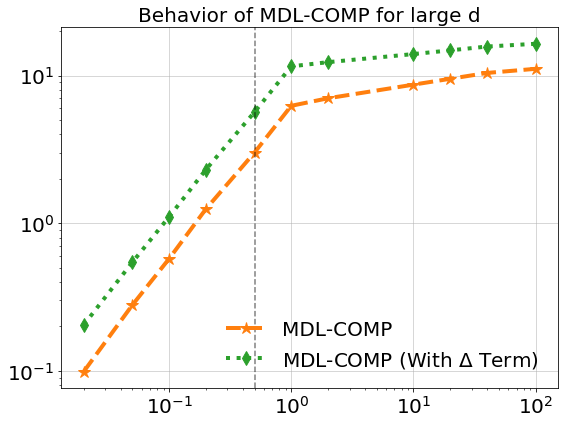

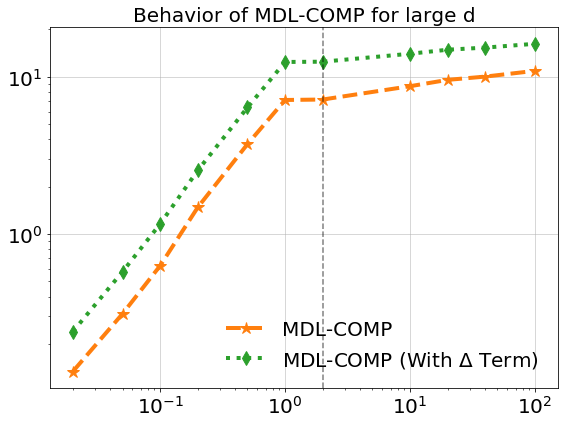

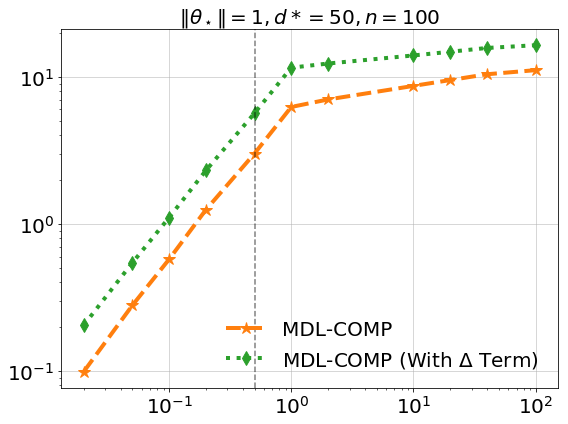

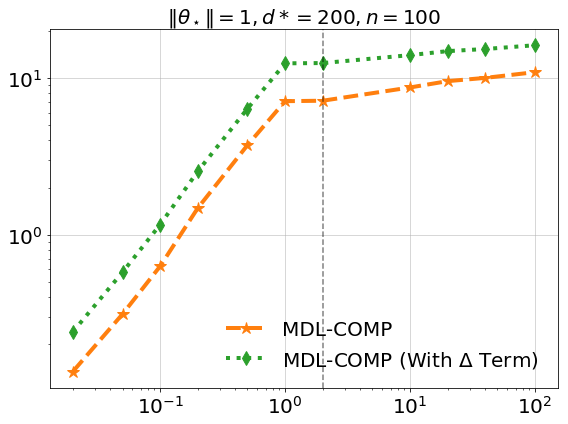

In [26]:
save_fig = True
num_norms = results["num_norms"]
d0s = results["d0s"]
ns = results["ns"]
ds = results["ds"]
rmt_mdl_comp = results["rmt_mdl_comp"]
rmt_mdl_comp_2 = results["rmt_mdl_comp_2"]
rmt_mdl_comp_3 = results["rmt_mdl_comp_3"]


n = ns[0]
gammas = ds/n
for prefix in ['generic_', 'detailed_']:
    for l, d0 in enumerate(d0s):
        for i in range(num_norms):
            plt.figure(figsize=[8, 6])
#             plt.loglog(gammas, rmt_mdl_comp.mean(0)[i, :, 0, l],   color=cs[0], linestyle='-', linewidth=4.,  marker='s',  markersize=10, label='MDL-COMP')
            plt.loglog(gammas, rmt_mdl_comp_2.mean(0)[i, :, 0, l],  color=cs[1], linestyle='--', linewidth=4.,  marker='*',  markersize=12, label='MDL-COMP')
            plt.loglog(gammas, rmt_mdl_comp_3.mean(0)[i, :, 0, l], color=cs[2],   linestyle=':', linewidth=4.,  marker='d',  markersize=10, label=r'MDL-COMP (With $\Delta$ Term) ')
            plt.axvline(d0/n, color='k', linestyle='--', alpha=0.5, )
            plt.grid(True, alpha=0.5, linewidth=1.)
            plt.legend(frameon=False, fontsize=20)    
    #         plt.legend()
            if prefix == 'generic_':
                plt.title(r'Behavior of MDL-COMP for large d', fontsize=20)
            else:
                plt.title(r'$\Vert \theta_\star \Vert = %d, d*=%d, n=%d$'%((i+1)**2, d0, n),  fontsize=20)
            plt.tight_layout()
            if save_fig:
                plt.savefig('fig2/'+prefix+'new_mdl_comp_d0_%d_norm_%d_n_%d_noise_std_%d.pdf'%(d0, (i+1)**2, n, noise_std))
            plt.show()